# Previsão Mensal de Crimes em Toronto com LSTM (PyTorch)
Este notebook utiliza dados agregados por mês para prever a quantidade total de crimes em Toronto usando PyTorch. A visualização segue o estilo tradicional de gráficos temporais com histórico e previsão.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando dispositivo:', device)

Usando dispositivo: cpu


            count    scaled
OCC_DATE                   
2014-01-31   2601  0.202855
2014-02-28   2262  0.056228
2014-03-31   2508  0.162630
2014-04-30   2576  0.192042
2014-05-31   2914  0.338235


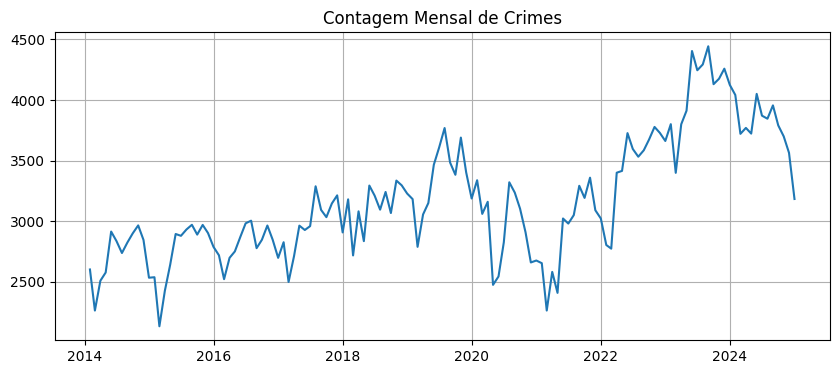

In [43]:
df = pd.read_csv('C:/Users/peder/Downloads/major-crime-indicators.csv', on_bad_lines='skip', parse_dates=['OCC_DATE'])
df = df[df['OCC_DATE'].notna()].sort_values('OCC_DATE')
ts = df.set_index('OCC_DATE').resample('M').size().to_frame('count')
ts = ts[ts.index >= '2014-01-01']
scaler = MinMaxScaler()
ts['scaled'] = scaler.fit_transform(ts[['count']])
data = ts['scaled'].values
print(ts.head())
plt.figure(figsize=(10,4))
plt.plot(ts.index, ts['count'])
plt.title('Contagem Mensal de Crimes')
plt.grid(True)
plt.show()

In [44]:

seq_length = 12
X, y = [], []
for i in range(len(data) - seq_length):
    X.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
X = np.array(X)
y = np.array(y)
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=8, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=8, shuffle=False)

class LSTMModel(nn.Module):  
    def __init__(self, input_size=1, hidden_size=32, dropout=0.2):
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.linear(out).squeeze()

model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [62]:
for epoch in range(500):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.0004
Epoch 2, Loss: 0.0003
Epoch 3, Loss: 0.0003
Epoch 4, Loss: 0.0003
Epoch 5, Loss: 0.0003
Epoch 6, Loss: 0.0003
Epoch 7, Loss: 0.0003
Epoch 8, Loss: 0.0004
Epoch 9, Loss: 0.0006
Epoch 10, Loss: 0.0007
Epoch 11, Loss: 0.0007
Epoch 12, Loss: 0.0004
Epoch 13, Loss: 0.0004
Epoch 14, Loss: 0.0004
Epoch 15, Loss: 0.0004
Epoch 16, Loss: 0.0004
Epoch 17, Loss: 0.0004
Epoch 18, Loss: 0.0004
Epoch 19, Loss: 0.0004
Epoch 20, Loss: 0.0003
Epoch 21, Loss: 0.0002
Epoch 22, Loss: 0.0004
Epoch 23, Loss: 0.0003
Epoch 24, Loss: 0.0005
Epoch 25, Loss: 0.0002
Epoch 26, Loss: 0.0003
Epoch 27, Loss: 0.0003
Epoch 28, Loss: 0.0003
Epoch 29, Loss: 0.0004
Epoch 30, Loss: 0.0003
Epoch 31, Loss: 0.0003
Epoch 32, Loss: 0.0003
Epoch 33, Loss: 0.0004
Epoch 34, Loss: 0.0004
Epoch 35, Loss: 0.0004
Epoch 36, Loss: 0.0003
Epoch 37, Loss: 0.0003
Epoch 38, Loss: 0.0003
Epoch 39, Loss: 0.0003
Epoch 40, Loss: 0.0004
Epoch 41, Loss: 0.0003
Epoch 42, Loss: 0.0003
Epoch 43, Loss: 0.0003
Epoch 44, Loss: 0.00

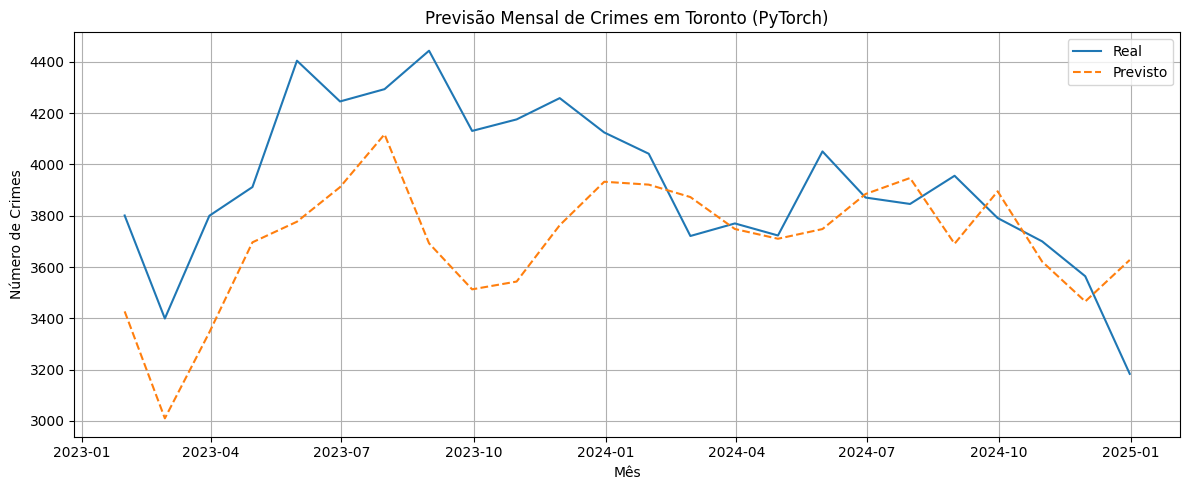

In [63]:
model.eval()
predictions = []
real_values = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch)
        predictions.extend(output.cpu().numpy())
        real_values.extend(y_batch.numpy())

predicted_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
real_inv = scaler.inverse_transform(np.array(real_values).reshape(-1, 1))

start_index = len(ts) - len(real_inv)
time_axis = ts.index[start_index:]

plt.figure(figsize=(12,5))
plt.plot(time_axis, real_inv, label='Real')
plt.plot(time_axis, predicted_inv, label='Previsto', linestyle='--')
plt.title('Previsão Mensal de Crimes em Toronto (PyTorch)')
plt.xlabel('Mês')
plt.ylabel('Número de Crimes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()